In [2]:
import pvlib

# Technology Exploration

Technologies in pvlib are packaged with NREL's SAM (System Advisor Model).
In particular, the databases are
1. CEC module database: thousands of modules with fitted parameters.
2. CEC inverter database: thousands of inverters.
3. Sandia module/inverter datasets: fewer, but highly detailed.

#### PV modules

In [3]:
cecm = pvlib.pvsystem.retrieve_sam('cecmod')
sandiam = pvlib.pvsystem.retrieve_sam('sandiamod')

In [4]:
print('number of PV modules in CEC database: ', len(cecm.columns))
print('number of PV modules in SANDIA database: ', len(sandiam.columns))
print('number of features in CEC database for each PV module: ', len(cecm.index))
print('number of features in SANDIA database for each PV module: ', len(sandiam.index))

number of PV modules in CEC database:  21535
number of PV modules in SANDIA database:  523
number of features in CEC database for each PV module:  25
number of features in SANDIA database for each PV module:  42


#### CEC PV Modules

let's investigate the metadata concerning each PV module.

In [5]:
print('The metadata concerining each PV module is described by the following names: ')
print('#############################################################################')
for metadata_name in cecm.index:
    print('metadata description: ', metadata_name, ' metadata type: ', type(cecm.loc[metadata_name].values[0]))
print('#############################################################################')

The metadata concerining each PV module is described by the following names: 
#############################################################################
metadata description:  Technology  metadata type:  <class 'str'>
metadata description:  Bifacial  metadata type:  <class 'int'>
metadata description:  STC  metadata type:  <class 'float'>
metadata description:  PTC  metadata type:  <class 'float'>
metadata description:  A_c  metadata type:  <class 'float'>
metadata description:  Length  metadata type:  <class 'float'>
metadata description:  Width  metadata type:  <class 'float'>
metadata description:  N_s  metadata type:  <class 'int'>
metadata description:  I_sc_ref  metadata type:  <class 'float'>
metadata description:  V_oc_ref  metadata type:  <class 'float'>
metadata description:  I_mp_ref  metadata type:  <class 'float'>
metadata description:  V_mp_ref  metadata type:  <class 'float'>
metadata description:  alpha_sc  metadata type:  <class 'float'>
metadata description:  beta_

In [6]:
print('possible technologies for the PV modules: ')
set(cecm.loc['Technology'].values)

possible technologies for the PV modules: 


{'CIGS', 'CdTe', 'Mono-c-Si', 'Multi-c-Si', 'Thin Film'}

In [7]:
print('-- Bifacial indicates whether the PV module is bifacial (1) or not (0)')
print('-- STC stands for Standard Test Conditions power, corresponding to 1000 W/m² irradiance, 25 °C cell temp, AM1.5 spectrum')
print('-- PTC stands for PVUSA Test Conditions power, corresponding to 1000 W/m² irradiance, 20 °C ambient, 1 m/s wind, 1.5 air mass')
print('-- A_c represents the aperture area of the PV module (m^2), the Length is its length (m), the Width is its width (m)')
print('-- N_s is the number of cells connected in series in the PV module')
print('-- I_sc_ref (reference circuit voltage) is the currect (A) when voltage is 0 at STC')
print('-- V_oc_ref (reference circuit voltage) is the voltage (V) at zero current at STC')
print('-- I_mp_ref is the current at maximum power point at STC (A)')
print('-- V_mp_ref is the Voltage at maximum power point at STC (V)')
print('-- alpha_sc is the Temperature coefficient of short-circuit current (A/°C), and captures how current rises with temperature')
print('-- beta_oc is the Temperature coefficient of open-circuit voltage (V/°C), and captures how voltage drops as temperature rises')
print('-- T_NOCT is the nominal operating cell temperature, Temperature the cells reach under “NOCT conditions”: 800 W/m² irradiance, 20 °C ambient, 1 m/s wind, open rack')
print('-- a_ref is the Modified diode ideality factor × number of cells × thermal voltage (at STC), and it Governs the exponential diode behavior (slope of I–V curve)')
print('-- I_L_ref is the Light-generated current at reference conditions (A)')
print('-- I_o_ref is the Diode saturation current at reference conditions (A)')
print('-- R_s is the series resistance (Ω)')
print('-- R_sh_ref is the Shunt resistance at STC (Ω), Low values lead to high leakage and poor low-voltage performance.')
print('-- Adjust is the Empirical adjustment factor used in parameter fitting. It helps match the modeled I–V curve to measured points.')
print('-- gamma_r is the Temperature coefficient of Pmp (maximum power) (%/°C), and Tells how efficiency degrades with temperature')
print('-- BIPV indicates whether the PV module is building-integrated (1) or not (0)')
print('-- Version is the version of the CEC database')
print('-- Date is the last update of the PV module')

-- Bifacial indicates whether the PV module is bifacial (1) or not (0)
-- STC stands for Standard Test Conditions power, corresponding to 1000 W/m² irradiance, 25 °C cell temp, AM1.5 spectrum
-- PTC stands for PVUSA Test Conditions power, corresponding to 1000 W/m² irradiance, 20 °C ambient, 1 m/s wind, 1.5 air mass
-- A_c represents the aperture area of the PV module (m^2), the Length is its length (m), the Width is its width (m)
-- N_s is the number of cells connected in series in the PV module
-- I_sc_ref (reference circuit voltage) is the currect (A) when voltage is 0 at STC
-- V_oc_ref (reference circuit voltage) is the voltage (V) at zero current at STC
-- I_mp_ref is the current at maximum power point at STC (A)
-- V_mp_ref is the Voltage at maximum power point at STC (V)
-- alpha_sc is the Temperature coefficient of short-circuit current (A/°C), and captures how current rises with temperature
-- beta_oc is the Temperature coefficient of open-circuit voltage (V/°C), and captures

#### The use for such metadata

The parameters inside the CEC database are needed to use the Single-Diode model. Such model enables the calculation of the I-V curve, and finally of the power vs. the voltage.
The inverter will try to operate to keep the values of voltage and current *at the knee* of the I-V curve, to maximize power.

Using: A10Green_Technology_A10J_S72_175
{'i_sc': 5.170000231299618, 'v_oc': 43.99000612100144, 'i_mp': 4.78000035907775, 'v_mp': 36.63000478464775, 'p_mp': 175.09143602363596}


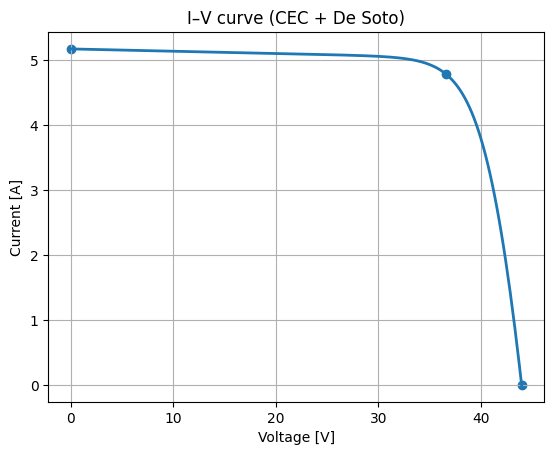

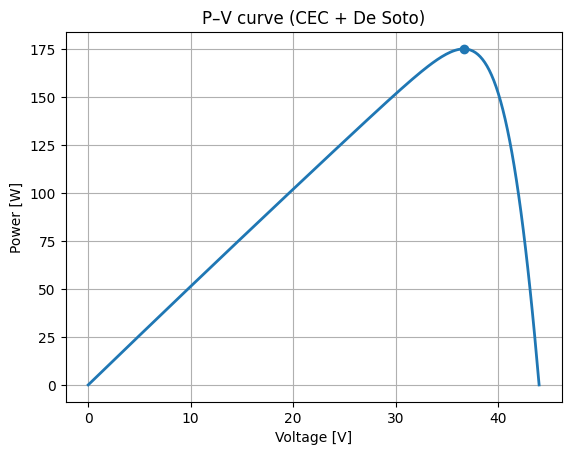

In [ ]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt

# 1) Load CEC database and pick a module
module_name = cecm.columns[0]      # or filter by substring
mod = cecm[module_name]
print("Using:", module_name)

# 2) Operating conditions
Geff = 1000.0    # effective POA irradiance [W/m^2]
Tcell = 25.0     # cell temperature [°C]

# 3) De Soto parameter scaling -> SDM parameters at (Geff, Tcell)
IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
    effective_irradiance=Geff,
    temp_cell=Tcell,
    alpha_sc=mod['alpha_sc'],
    a_ref=mod['a_ref'],
    I_L_ref=mod['I_L_ref'],
    I_o_ref=mod['I_o_ref'],
    R_sh_ref=mod['R_sh_ref'],
    R_s=mod['R_s'],
    # EgRef, dEgdT have sensible defaults; include if you want explicit values
)

# 4) Key points (Isc, Voc, Imp, Vmp, Pmp)
sd = pvlib.pvsystem.singlediode(
    photocurrent=IL, saturation_current=I0,
    resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth,
    method='lambertw'    # or 'newton' if you prefer
)
print({k: float(sd[k]) for k in ['i_sc','v_oc','i_mp','v_mp','p_mp']})

# 5) Sample the I–V curve using i_from_v on a voltage grid up to Voc
V = np.linspace(0.0, float(sd['v_oc']), 200)
I = pvlib.pvsystem.i_from_v(
    voltage=V, photocurrent=IL, saturation_current=I0,
    resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth,
    method='lambertw'
)
P = V * I

# 6) Plot
plt.figure()
plt.plot(V, I, lw=2)
plt.scatter([0, sd['v_oc'], sd['v_mp']], [sd['i_sc'], 0, sd['i_mp']])
plt.xlabel("Voltage [V]"); plt.ylabel("Current [A]")
plt.title("I–V curve (CEC + De Soto)"); plt.grid(True)

plt.figure()
plt.plot(V, P, lw=2)
plt.scatter([sd['v_mp']], [sd['p_mp']])
plt.xlabel("Voltage [V]"); plt.ylabel("Power [W]")
plt.title("P–V curve (CEC + De Soto)"); plt.grid(True)
plt.show()

### Temperature Model

PV modules heat up above ambient temperature depending on:

1. Mounting configuration (open-rack vs rooftop),
2. Backsheet/glass type,
3. Wind speed,
4. Irradiance.

Cell temperature is important because module efficiency drops as temperature rises.
pvlib provides a few common temperature models. One of them is the Sandia Array Performance Model (SAPM) temperature model, which needs three coefficients:

1. a (slope vs ambient temperature),
2. b (slope vs wind speed),
3. ΔT (temperature rise at NOCT conditions).

#### Important Note:
The SAPM temperature parameters (calculated experimentally -- Sandia labs) are only needed when you don’t know Tcell and want pvlib to compute it from weather + mounting (irradiance, ambient temp, wind, rack type).

In [11]:
pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']

{'open_rack_glass_glass': {'a': -3.47, 'b': -0.0594, 'deltaT': 3},
 'close_mount_glass_glass': {'a': -2.98, 'b': -0.0471, 'deltaT': 1},
 'open_rack_glass_polymer': {'a': -3.56, 'b': -0.075, 'deltaT': 3},
 'insulated_back_glass_polymer': {'a': -2.81, 'b': -0.0455, 'deltaT': 0}}

PVSyst uses yet another empirical model, replicable with pvlib.

In [16]:
pvlib.temperature.pvsyst_cell

<function pvlib.temperature.pvsyst_cell(poa_global, temp_air, wind_speed=1.0, u_c=29.0, u_v=0.0, module_efficiency=0.1, alpha_absorption=0.9)>

Tcell = pvlib.temperature.pvsyst_cell(
    
    poa_global,             # W/m² plane-of-array irradiance

    temp_air,               # °C ambient

    wind_speed=,            # m/s wind speed

    u_c=29.0,               # default free-standing/open-rack

    u_v=0.0,                # wind dependence coeff

    eta_m,                 # module efficiency (fraction)

    alpha_absorption=0.9    # absorptance
)

eta_m=V_mp_ref * I_mp_ref / (1000⋅A_c)

In [27]:
ceci = pvlib.pvsystem.retrieve_sam('cecinverter')
sandiai = pvlib.pvsystem.retrieve_sam('sandiainverter')

Valid surface_type values (pvlib presets) instead of presetting an albedo coefficient

urban (0.18)
grass (0.20)
fresh grass (0.26)
soil (0.17)
sand (0.40)
snow (0.65)
fresh snow (0.75)
asphalt (0.12)
concrete (0.30)
aluminum (0.85)
copper (0.74)
fresh steel (0.35)
dirty steel (0.08)
sea (0.06)